# Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import tensorflow as tf

from helpers import parse_variables, get_risk_level, map_to_color, simulate_quant_trait
from models import ols_regression, manhattan_linear, gc
from deep_learning_models import abyss, deep_abyss

from scipy.stats import t
from scipy import stats
from scipy.stats import entropy

from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from tensorflow.keras import Input, Model, layers, regularizers
from tensorflow.keras.layers import Input, Dense


2024-08-16 14:47:20.693688: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-16 14:47:20.696781: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-16 14:47:20.707527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 14:47:20.727815: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 14:47:20.727861: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-16 14:47:20.741855: I tensorflow/core/platform/cpu_feature_guard.cc:

In [2]:
# Names of the environmental risks
naming_dict = {
    "no_risk": "no environmental risk",
    "NW_risk": "Smooth linear North-West environmental risk",
    "N_risk" : "Smooth linear North environmental risk",
    "blob_risk": "Localised big blob risk",
    "center_risk": "Localised big central risk",
    "big_square_risk": "big square risk",
    "square_risk" : "Tiny square risk",
    'hi_square_risk' : "Tiny square risk",
    "hi_gauss_blob_risk": "Global Gaussian Risk",
    "two_square_risk": "Two tiny risks",
    "gauss_blob_risk" : "Gaussian Risk",
    "three_square_risk": "Three localized Risks",
    "mid_mid_square_risk": "Mid square risk"
}

In [3]:
risks = list(naming_dict.keys())

In [4]:
# Load genotype

In [5]:
dict = parse_variables('geno_simulation.txt')
G = int(dict['G'])
L = int(dict['L'])
c = int(dict['c'])
k = int(dict['k'])
M = float(dict['M'])

# Thresholds
very_rare_threshold_L = float(dict['very_rare_threshold_L'])
very_rare_threshold_H = float(dict['very_rare_threshold_H'])

rare_threshold_L = float(dict['rare_threshold_L'])
rare_threshold_H = float(dict['rare_threshold_H'])

common_threshold_L = float(dict['common_threshold_L'])
common_threshold_H = float(dict['common_threshold_H'])

number_of_snps = (G*L)/2 # one loci per chromosome
number_of_individuals = c*k*k

In [6]:
very_rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_rare_genotype_AF_{rare_threshold_L}_{rare_threshold_H}.pkl")
common = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")

In [7]:
very_rare = very_rare.rename(columns=lambda x: 'VR' + x)/2
#very_rare = very_rare.iloc[::-1].reset_index(drop=True)
rare = rare.rename(columns=lambda x: 'R' + x)/2
common = common.rename(columns=lambda x: 'C' + x)/2
complete = pd.concat([common, rare, very_rare], axis=1)
complete = ((complete*2)-1)

In [8]:
# Load population

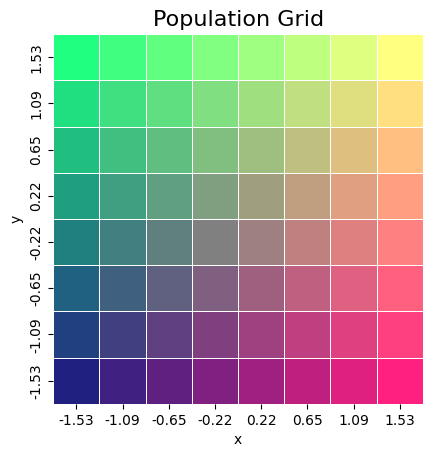

In [9]:
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/01_population_structure.pkl")
populations['population_number'] = populations['populations'].str.extract('(\d+)').astype(int)
# Calculating X and Y coordinates
populations['x'] = ((populations['population_number'] - 1) % k) + 1
populations['y'] = ((populations['population_number'] - 1) // k) + 1
populations['z'] = 0.5
populations['population'] = populations['population_number']/(k*k)
palette = [map_to_color(x, y, z, populations) for x, y, z in zip(populations['x'], populations['y'], populations['z'])]

# Standardize the vector
std_dev = np.std(populations['x'])
mean = np.mean(populations['x'])
populations['x'] = np.round((populations['x'] - mean) / std_dev,2)

std_dev = np.std(populations['y'])
mean = np.mean(populations['y'])
populations['y'] = np.round((populations['y'] - mean) / std_dev,2)

# Check the grid
df_agg = populations.groupby(['x', 'y']).agg({'population': 'mean'}).reset_index()

# Now, pivot the aggregated DataFrame
grid_df = df_agg.pivot(index='y', columns='x', values='population')


heatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title('Population Grid', fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()

In [10]:
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/01_population_structure.pkl")

In [11]:
true_p2s = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/true_p2_via_true_pop.pkl")
true_twopqs = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/true_twopq_via_true_pop.pkl")
true_q2s = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/true_q2_via_true_pop.pkl")

In [12]:
onehotpops = pd.get_dummies(populations[['populations']], columns=['populations']).astype(int)

In [13]:
# PCA
nr_common_PCs = 24
pc_columns = ['PC{}'.format(i) for i in range(1, nr_common_PCs+1)]
PC_common= pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/PCs/common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")

In [14]:
p2_0 = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/esti_p2_zoom_0_via_esti_pop.pkl")
twopq_0 = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/esti_2pq_zoom_0_via_esti_pop.pkl")
q2_0 = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/esti_q2_zoom_0_via_esti_pop.pkl")

In [15]:
covariate_dictionary_true = {}
for snp in list(complete.columns):
    temp = complete[[snp]].copy()
    temp[f"{snp}_cov_p_q"] = true_p2s[snp] - true_q2s[snp]
    temp[f"{snp}_cov_2pq"] = true_twopqs[snp]
    temp = temp.drop(columns=[snp])
    covariate_dictionary_true[snp] = temp

In [16]:
covariate_dictionary_esti_0 = {}
for snp in list(complete.columns):
    temp = complete[[snp]].copy()
    temp[f"{snp}_cov_p2"] = p2_0[snp]
    temp[f"{snp}_cov_q2"] = q2_0[snp]
    temp[f"{snp}_cov_2pq"] = twopq_0[snp]
    temp = temp.drop(columns=[snp])
    covariate_dictionary_esti_0[snp] = temp

In [17]:
PC_common

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC46,PC47,PC48,PC49,PC50,populations,population_number,x,y,population
0,-5.594652,-7.579343,-2.902215,-0.938317,2.139569,7.513270,-5.426414,-6.663947,0.822353,1.766709,...,-2.482481,0.756156,0.177441,0.732427,0.008800,pop 1,0.015625,1,1,1
1,-4.766269,-5.462878,-3.199703,-1.511901,2.021670,7.203385,-5.834887,-6.178474,0.071939,1.000203,...,0.461944,-0.659570,0.436738,-0.451067,-1.664872,pop 1,0.015625,1,1,1
2,-4.536103,-6.589765,-2.879228,0.292894,2.454214,4.793158,-6.015889,-6.923120,-0.359603,2.797775,...,0.066403,-0.732898,0.271856,0.275075,0.595871,pop 1,0.015625,1,1,1
3,-5.438806,-7.248564,-3.614164,0.063486,1.723205,4.904838,-5.357202,-6.539005,-0.768245,1.646384,...,-0.935378,0.440870,1.027584,0.906252,-0.745119,pop 1,0.015625,1,1,1
4,-4.244182,-6.971952,-4.900547,-0.853879,2.284388,5.675895,-6.818460,-5.626986,-0.087582,1.303172,...,0.330353,-0.489129,0.157091,0.959139,-1.296372,pop 1,0.015625,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,4.794610,7.770171,2.414024,-1.512700,-2.222629,4.195125,0.689601,-6.333770,5.264003,-1.996550,...,-0.559416,-0.246742,0.583779,0.871658,-1.466939,pop 64,1.000000,8,8,64
3196,4.736072,8.869085,0.789369,0.172025,-2.237078,3.721864,1.080797,-7.452781,6.262733,-1.513461,...,-0.898622,-0.346269,0.236852,0.916166,-0.201098,pop 64,1.000000,8,8,64
3197,5.083458,9.341955,2.607159,-1.064460,-2.633349,3.860970,0.814101,-6.867102,5.858745,-2.011744,...,1.229108,-0.235342,1.235700,-0.119840,0.028315,pop 64,1.000000,8,8,64
3198,5.229621,9.667318,1.071426,0.651901,-0.801895,3.893496,0.171765,-5.878255,7.954476,-2.205272,...,0.647777,0.358448,0.818049,0.457596,-0.922701,pop 64,1.000000,8,8,64


In [18]:
covariate_dictionary_combi = {}
for snp in list(complete.columns):
    temp = complete[[snp]].copy()
    temp[f"{snp}_cov_p2"] = p2_0[snp]
    temp[f"{snp}_cov_q2"] = q2_0[snp]
    temp[f"{snp}_cov_2pq"] = twopq_0[snp]
    temp[pc_columns] = PC_common[pc_columns]
    temp = temp.drop(columns=[snp])
    covariate_dictionary_combi[snp] = temp

In [19]:
mu= np.zeros(complete.shape[0])
beta = np.zeros(complete.shape[1])
noise = 0.05

In [20]:
path_plots = f"data/G{G}_L{L}_c{c}_k{k}_M{M}/plots/"

In [21]:
os.makedirs(path_plots, exist_ok=True)

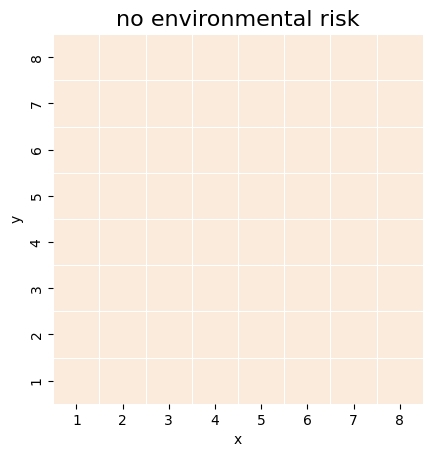

Global phenotype
No Covs!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Covs


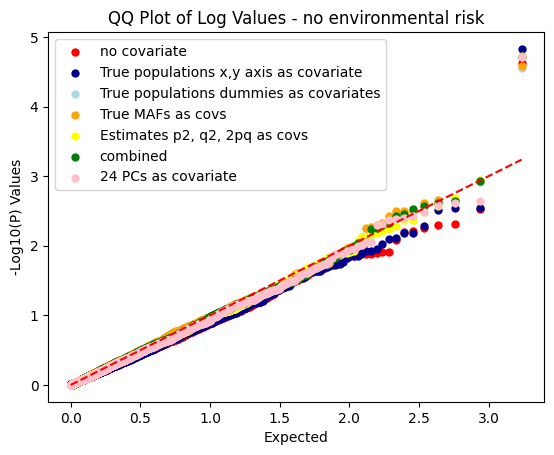

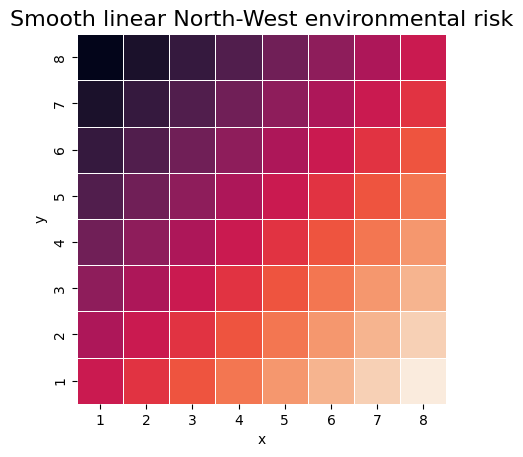

Global phenotype
No Covs!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Covs


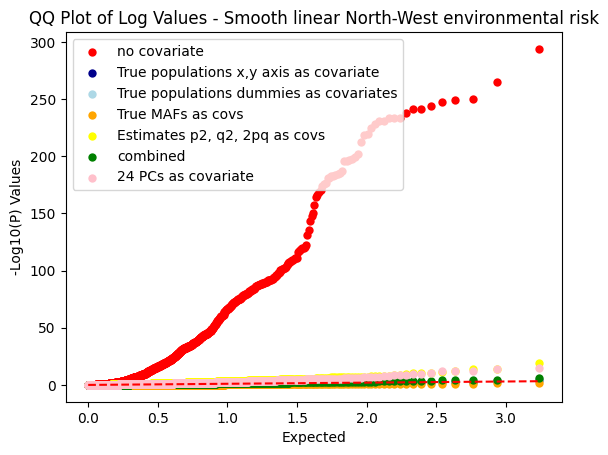

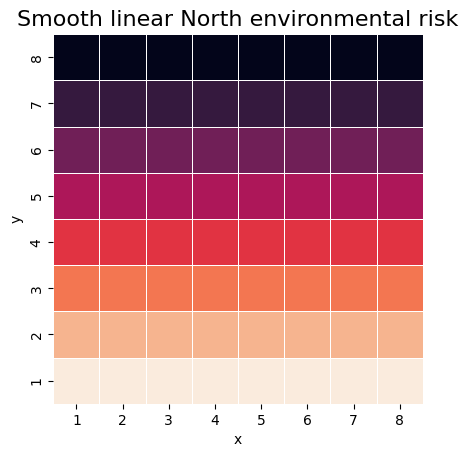

Global phenotype
No Covs!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Covs


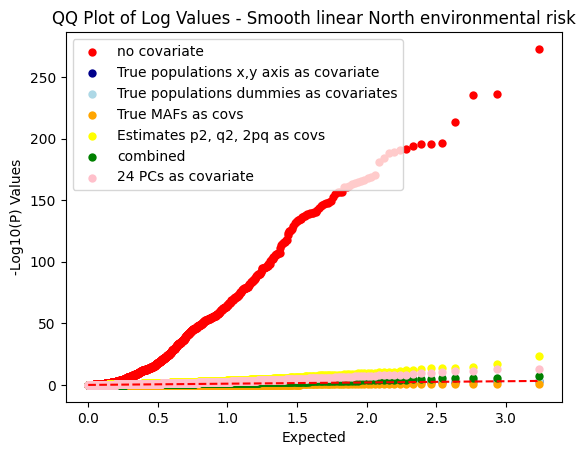

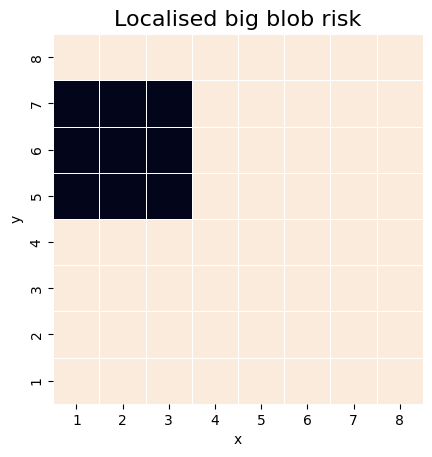

Global phenotype
No Covs!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Covs


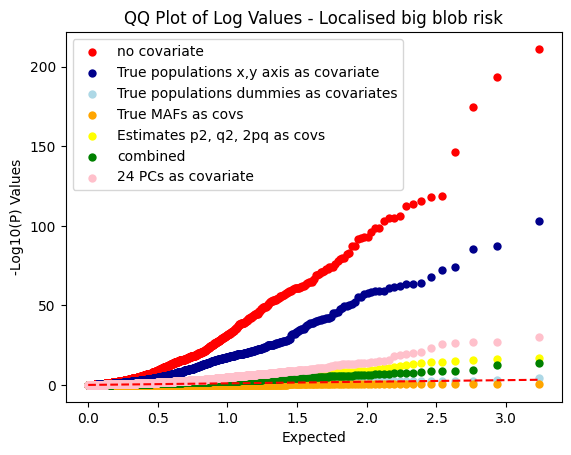

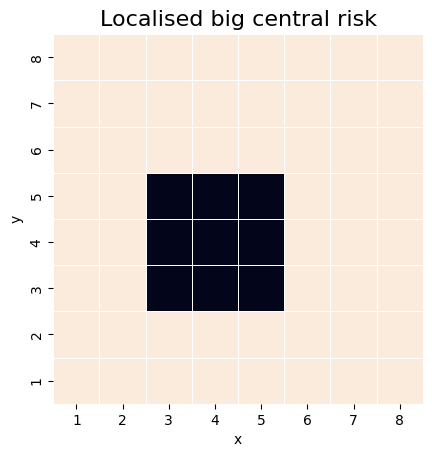

Global phenotype
No Covs!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Covs


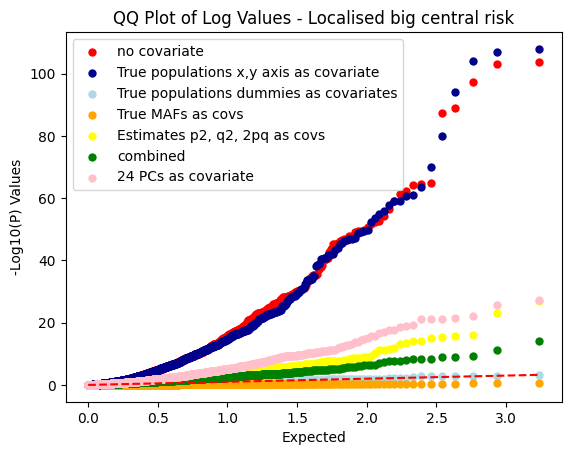

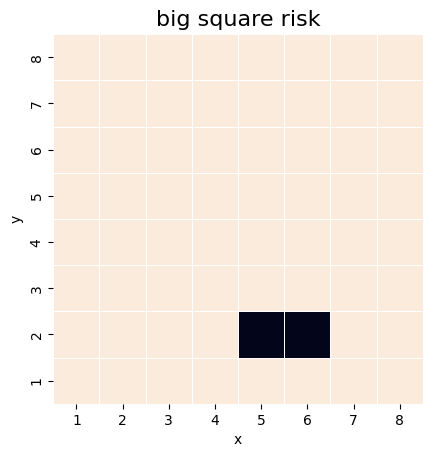

Global phenotype
No Covs!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Covs


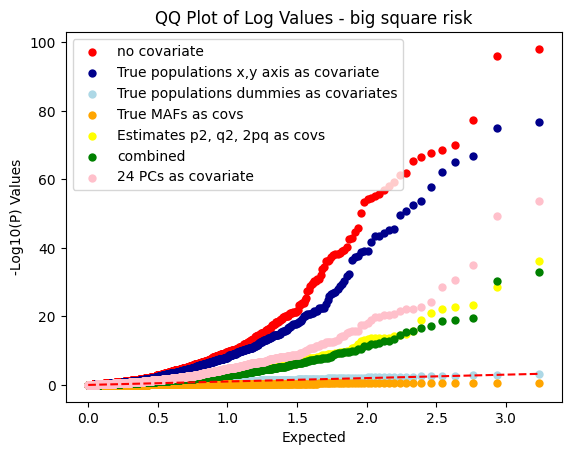

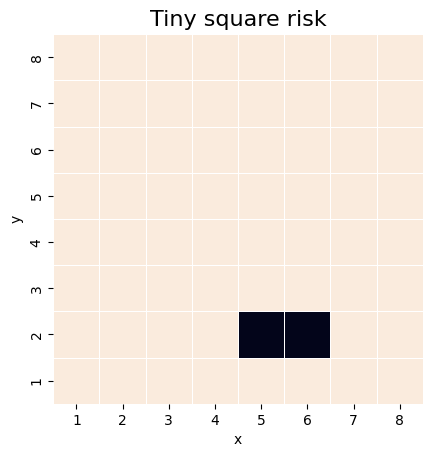

Global phenotype
No Covs!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Covs


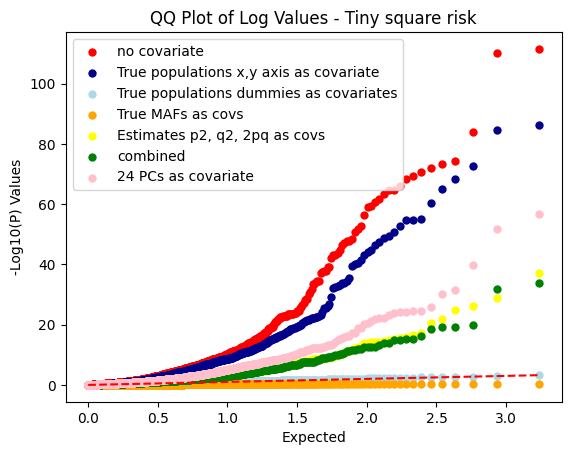

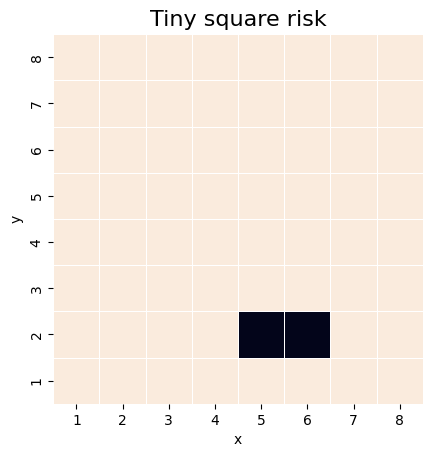

Global phenotype
No Covs!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Covs


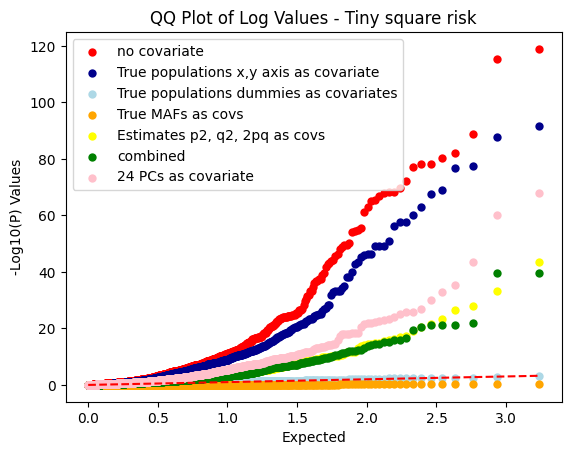

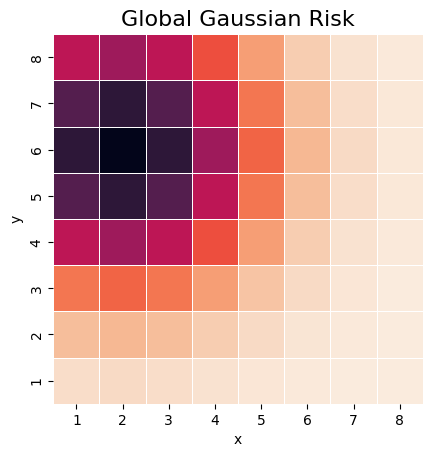

Global phenotype
No Covs!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Covs


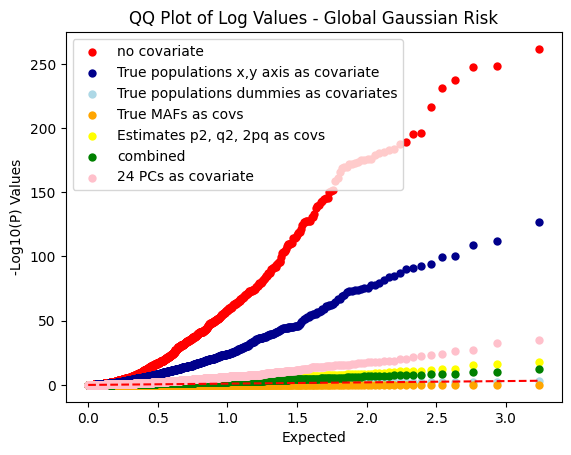

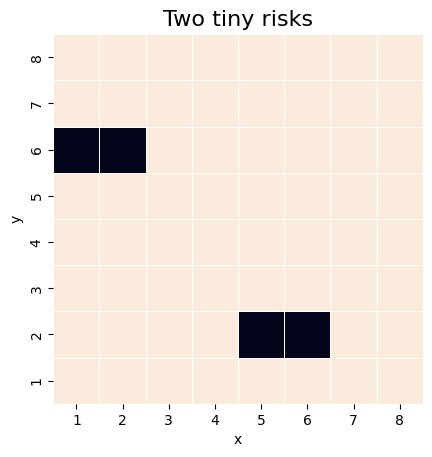

Global phenotype
No Covs!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Covs


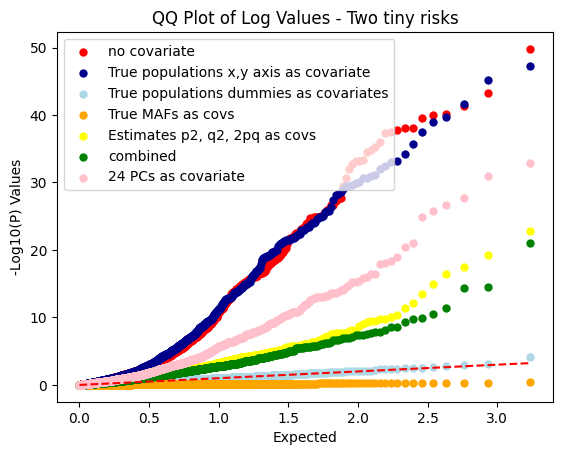

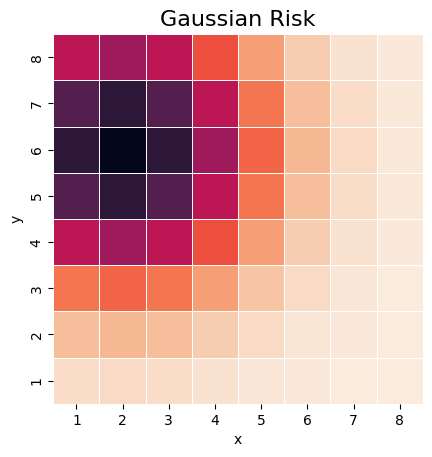

Global phenotype
No Covs!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Covs


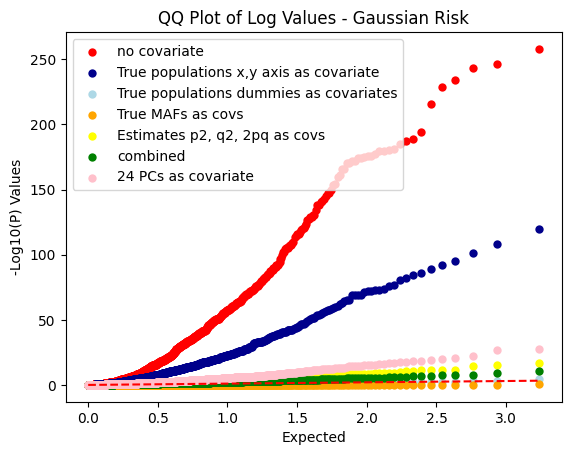

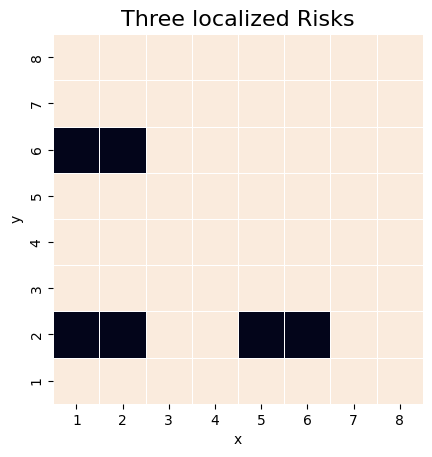

Global phenotype
No Covs!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Covs


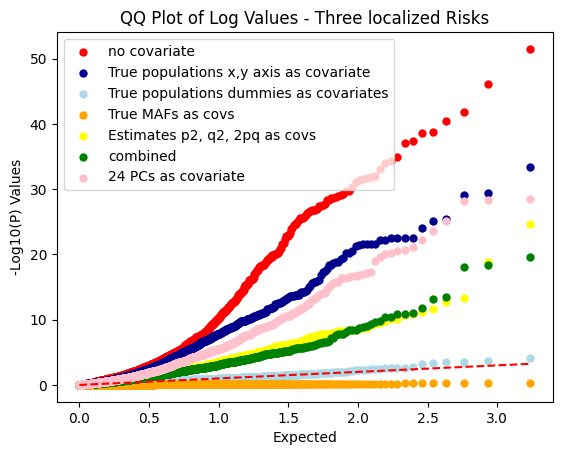

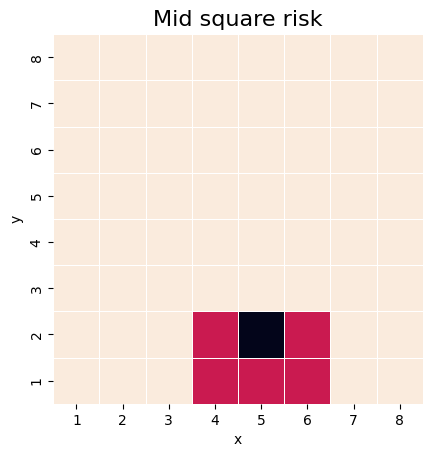

Global phenotype
No Covs!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Covs
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Dictionary Match!
Pheno is not None and not a dataframe
Covs


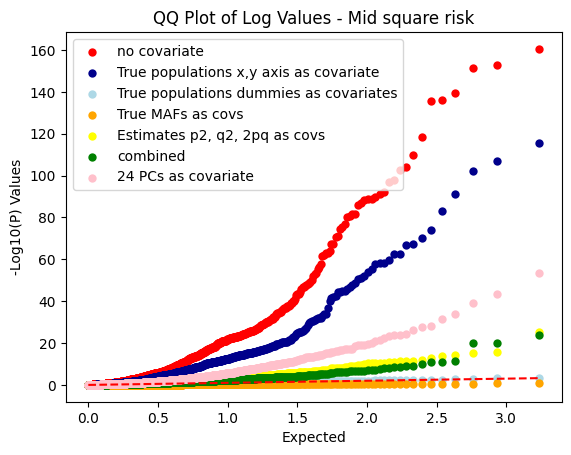

In [22]:
for name_risk in risks:
    risk = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/environmental_risks/risk_{name_risk}.pkl")
    populations[name_risk] = risk[name_risk]
    df_agg = populations.groupby(['x', 'y']).agg({name_risk: 'mean'}).reset_index()
    grid_df = df_agg.pivot(index='y', columns='x', values=name_risk)
    sns.heatmap(grid_df, cmap='rocket_r', linewidths=.5, square=True, cbar=False)
    
    # Add a title to the heatmap
    plt.title(f"{naming_dict[name_risk]}", fontsize=16)
    plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
    plt.savefig(f"{path_plots}/envriskmap_{name_risk}.png", dpi=100)

    plt.show()

    y = np.array(simulate_quant_trait(mu, np.array(complete), beta, np.array(risk[name_risk]), noise))
    # Calculate the standard deviation and mean
    std_dev = np.std(y)
    mean = np.mean(y)
    # Standardize
    y = (y - mean) / std_dev
    risk['pheno'] = y

    # No correction
    df_no_corr = manhattan_linear(complete, risk[['pheno']])

    # X and Y axis as covaraites
    pops = populations[['x','y']]
    df_pops = manhattan_linear(complete, y , pops)

    # p2 - q2 and 2pq as covariates

    df_p_q_2pq_covs_via_true_pops = manhattan_linear(complete, y, covariate_dictionary_true)
#    autoencoder, bottleneck_model, history = abyss(complete, complete, bottleneck_nr, epoch, patience)
    df_PCs = manhattan_linear(complete, y , PC_common[pc_columns])

    df_abyss_p_q_2pq_covs_via_esti_pop = manhattan_linear(complete, y, covariate_dictionary_esti_0)
    df_abyss_combined = manhattan_linear(complete, y, covariate_dictionary_combi)
    
    df_pops_onehot = manhattan_linear(complete, y , onehotpops)
    
    # Create QQ plot
    df_bests = pd.DataFrame()
    df_bests["-logP_no_corr"] = np.sort(df_no_corr['-logPs'])
    df_bests["-logP_true_pop"] = np.sort(df_pops['-logPs'])
    df_bests["-logP_true_pop_onehot"] = np.sort(df_pops_onehot['-logPs'])
    #df_bests["-logP_abyss_via_esti_pops"] = np.sort(df_abyss_p_q_covs_via_esti_pop['-logPs'])
    df_bests["-logP_abyss_via_true_pops"] = np.sort(df_p_q_2pq_covs_via_true_pops['-logPs'])
    df_bests["-logP_abyss_pq2pq_via_esti_pops"] = np.sort(df_abyss_p_q_2pq_covs_via_esti_pop['-logPs'])
    df_bests["-logP_combined"] = np.sort(df_abyss_combined['-logPs'])
    
    
    
    df_bests["-logP_PCs"] = np.sort(df_PCs['-logPs'])

    # Find the maximum value in the DataFrame excluding inf and NaN
    max_value = df_bests.replace([np.inf, -np.inf], np.nan).max().max()
    
    # Replace inf values with the maximum value found
    df_bests.replace([np.inf, -np.inf], max_value, inplace=True)
    
    # Replace NaN values with the maximum value found
    df_bests.fillna(max_value, inplace=True)
    n = len(df_bests)
    expected_quantiles = np.arange(1, n + 1) / n
    expected_logP = np.sort(-np.log10(expected_quantiles))
    df_bests['expected_logP'] = expected_logP

    sns.scatterplot(x='expected_logP', y='-logP_no_corr', data=df_bests, color='red', label='no covariate', linewidth=0)
    
    sns.scatterplot(x='expected_logP', y='-logP_true_pop', data=df_bests, color='darkblue', label='True populations x,y axis as covariate', linewidth=0)
    
    sns.scatterplot(x='expected_logP', y='-logP_true_pop_onehot', data=df_bests, color='lightblue', label='True populations dummies as covariates', linewidth=0)
    
    #sns.scatterplot(x='expected_logP', y='-logP_abyss_via_esti_pops', data=df_bests, color='purple', label='Estimated MAFs as covs', linewidth=0)
    sns.scatterplot(x='expected_logP', y='-logP_abyss_via_true_pops', data=df_bests, color='orange', label='True MAFs as covs', linewidth=0)
    sns.scatterplot(x='expected_logP', y='-logP_abyss_pq2pq_via_esti_pops', data=df_bests, color='yellow', label='Estimates p2, q2, 2pq as covs', linewidth=0)
    sns.scatterplot(x='expected_logP', y='-logP_combined', data=df_bests, color='green', label='combined', linewidth=0)
    
    sns.scatterplot(x='expected_logP', y='-logP_PCs', data=df_bests, color='pink', label=f"{nr_common_PCs} PCs as covariate", linewidth=0)
    
    # Plot diagonal reference line
    plt.plot([min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
             [min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
             color='red', linestyle='--')
    
    # Set plot labels and title
    plt.xlabel('Expected')
    plt.ylabel('-Log10(P) Values')
    plt.title(f"QQ Plot of Log Values - {naming_dict[name_risk]}")
    
    # Show legend
    
    plt.legend()
    plt.savefig(f"{path_plots}/qq_only_env_{name_risk}.png", dpi=100)
    # Show plot
    plt.show()